<a href="https://colab.research.google.com/github/Nacho2904/CURSO-LEARNING1/blob/tareas/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")


random_seed = 176249

Data successfully downloaded


# Clasificación de Orientaciones políticas

En este notebook vamos a tratar de predecir la orientación política del autor de una nota periodística a partir del texto de dicha nota.


El primer paso para ello es leer los datos. En este caso, se tiene un *data frame* con artículos de diarios y la anotación de la orientación política (*left*, *right* o *mainstream*).

In [2]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
  
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)
train_split

,mainText,orientation
0,#5. Denmark pays students $900 a month to atte...,left
1,Politico POLITICO's must-read briefing on what...,mainstream
2,Dear President Bush. I am interested in buying...,right
3,Just days after the University of North Dakota...,left
4,Washington (CNN)The Senate Wednesday rejected ...,mainstream
...,...,...
1279,The rioters in Charlotte may think they’re pro...,right
1280,"Last October, Hillary Clinton and her top aide...",mainstream
1281,Kansas is bleeding money and jobs and Governor...,left
1282,To cap off a week in which police officers sho...,left


In [11]:
train_split["mainText"][0]

'#5. Denmark pays students $900 a month to attend college. Thanks to Vermont Senator Bernie Sanders’ proud identification as a Democratic Socialist and allusion to Denmark as an ideal social democracy, Denmark is being discussed throughout the news media. But what few outlets are brave enough to report is that, by almost every measurable standard, Danish socialism runs circles around American capitalism. Here are a few examples:  Denmark has a tremendous social safety net for unemployed workers — any worker who worked at least 52 weeks over a three-year period can qualify to have 90 percent of their original salary paid for, for up to two years. The Danish government also has plentiful training programs for out-of-work Danes. As a result, 73 percent of Danes between 15 and 64 have a paying job, compared to 67 percent of Americans. World Bank data on healthcare costs in developed nations. According to the Organisation for Economic Co-Operation and Development (OECD), the US spends twice

Una práctica muy común para procesar texto es normalizarlo. Algunas técnicas comunes son:
* Eliminar caracteres raros e inusuales
* Convertir todo a minúsculas
* Eliminar palabras que no contienen información relevante (*stop words*)
* *Lemmatization*
* *Stemming*

In [9]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

train_data, test_data = read_data(test_size=0.2,random_state=random_seed)
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=None)
train_data

,mainText,orientation
0,5 denmark pays students 900 a month to attend ...,left
1,politico politicos mustread briefing on whats ...,mainstream
2,dear president bush i am interested in buying ...,right
3,just days after the university of north dakota...,left
4,washington cnnthe senate wednesday rejected a ...,mainstream
...,...,...
1279,the rioters in charlotte may think theyre prot...,right
1280,last october hillary clinton and her top aides...,mainstream
1281,kansas is bleeding money and jobs and governor...,left
1282,to cap off a week in which police officers sho...,left


In [10]:
train_data["mainText"][0]

'5 denmark pays students 900 a month to attend college thanks to vermont senator bernie sanders proud identification as a democratic socialist and allusion to denmark as an ideal social democracy denmark is being discussed throughout the news media but what few outlets are brave enough to report is that by almost every measurable standard danish socialism runs circles around american capitalism here are a few examples denmark has a tremendous social safety net for unemployed workers any worker who worked at least 52 weeks over a threeyear period can qualify to have 90 percent of their original salary paid for for up to two years the danish government also has plentiful training programs for outofwork danes as a result 73 percent of danes between 15 and 64 have a paying job compared to 67 percent of americans world bank data on healthcare costs in developed nations according to the organisation for economic cooperation and development oecd the us spends twice as much per capita on healt

Una vez preprocesado, es necesario definir el vocabulario. Es decir, el conjunto de palabras que van a ser consideradas en la extracción de *features*.

100%|██████████| 1284/1284 [00:01<00:00, 839.82it/s]


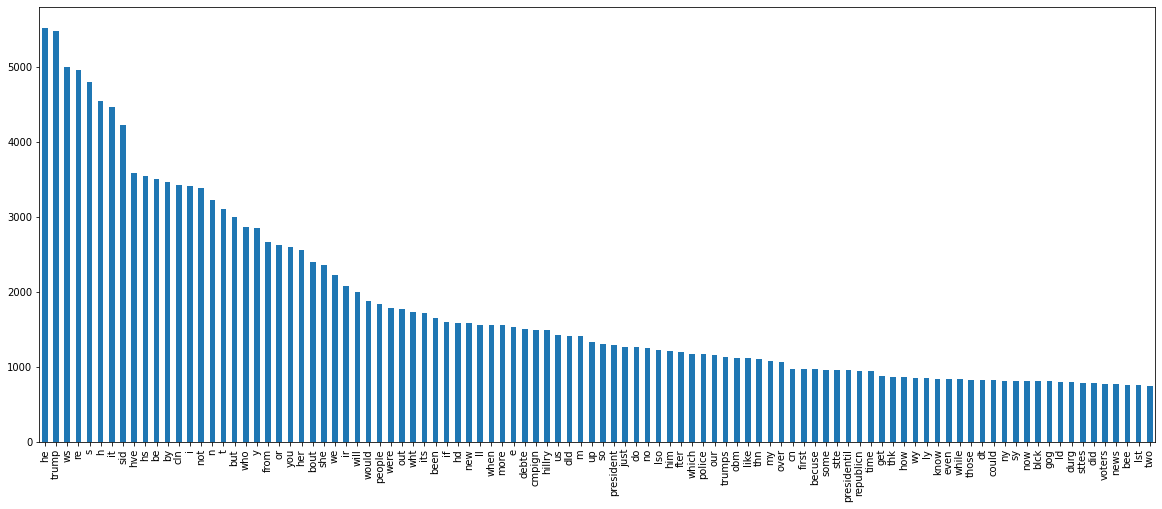

In [18]:
from nltk import word_tokenize
from collections import defaultdict

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on","is", "with"])
vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(False)

Una vez hecho esto, es posible vectorizar cada noticia haciendo lo que se conoce como una "bolsa de palabras" (*bag of words*). Es decir, cada documento (noticia) de la base de datos va a consistir en un vecor que contenga en sus componentes la cantidad de veces que aparecieron las palabras del vocabulario en él. 

In [23]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))

  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X
        

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])

vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

100%|██████████| 320/320 [00:00<00:00, 577.25it/s]


is          6941
he          5527
trump       5485
ws          5003
re          4840
            ... 
roseivey       5
chlked         5
mckenn         5
koltsov        5
nlytic         5
Length: 8953, dtype: int64

## Baseline

*Show time!* Ahora sí vamos a clasificar noticias. Cuando tenemos una base de datos nueva, una buena práctica es utilizar un modelo ingénuo (*dummy* o *naive*) para evaluarlo. En clasificación es muy común utilizar un modelo que aprende cuál fue la clase más frecuente durante el entrenamiento y elige siempre ésta cuando tiene que realizar una predicción. Esto puede implementarse fácilmente utilizando el objeto `DummyClassifier` de [scikit-learn](https://scikit-learn.org/stable/index.html).

Para evaluar nuestro clasificación vamos a utilizar algunas funciones de la librería `metrics` del mismo paquete. En particular, `plot_confusion_matrix` nos muestra la matriz de confusión del problema de clasificación.

Baseline model:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       166
           1       0.00      0.00      0.00       109
           2       0.00      0.00      0.00        45

    accuracy                           0.52       320
   macro avg       0.17      0.33      0.23       320
weighted avg       0.27      0.52      0.35       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


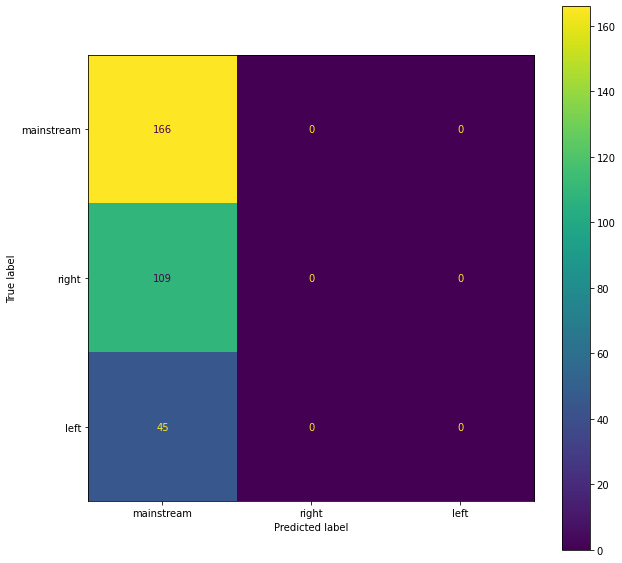

In [37]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

def show_results(y_true,y_pred):

  # Plot confusion matrix
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  dsp = metrics.ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=["mainstream", "right", "left"],ax=ax)

  # Show Classification report
  print(metrics.classification_report(y_true,y_pred))


clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train,y_train)
y_test_pred = clf.predict(X_test)
print("Baseline model:")
show_results(y_test,y_test_pred)

## BOW + Clasificador Softmax

**Tarea 1: Implementar una vectorización por bolsa de palabras y entrenar un clasificador Softmax para clasificar orientaciones políticas. Utilizar exactitud como métrica de evaluación.**

Analizar:
* ¿Funciona mejor el clasificador entrenado que el modelo baseline?
* ¿Cómo influye la cantidad de palabras elegidas? ¿Y la frecuencia mínima de aparición? 
* ¿Qué importancia tienen las stop words en este caso?
* ¿Hay overfitting? ¿Cómo podría reducirlo?

In [77]:
def get_and_bow_vectorize_data(
    stop_words=None,
    max_tokens=1000,
    min_freq=100
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=max_tokens,min_freq=min_freq)
  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_and_bow_vectorize_data()

# TODO: Implementar Softmax Classifier


100%|██████████| 320/320 [00:00<00:00, 487.21it/s]


In [75]:
np.shape(X_test)

(320, 39)

In [34]:
import tensorflow as tf
import seaborn as sns

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 26862     
                                                                 
Total params: 26,862
Trainable params: 26,862
Non-trainable params: 0
_________________________________________________________________


In [78]:
logistic_classifier = tf.keras.Sequential()
logistic_classifier.add(tf.keras.layers.Dense(3, input_dim=np.shape(X_train)[1], activation="softmax"))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
logistic_classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=["accuracy"])
hist = logistic_classifier.fit(x=X_train, y=y_train, batch_size = len(y_train), epochs=10000,callbacks=[early_stop]);

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 5ms/step - loss: 9.9892 - accuracy: 0.6526
Epoch 2198/10000
1/1 [==============================] - 0s 5ms/step - loss: 6.6726 - accuracy: 0.6519
Epoch 2199/10000
1/1 [==============================] - 0s 6ms/step - loss: 17.3138 - accuracy: 0.5935
Epoch 2200/10000
1/1 [==============================] - 0s 6ms/step - loss: 4.4098 - accuracy: 0.7134
Epoch 2201/10000
1/1 [==============================] - 0s 5ms/step - loss: 10.1609 - accuracy: 0.6854
Epoch 2202/10000
1/1 [==============================] - 0s 5ms/step - loss: 4.3880 - accuracy: 0.7274
Epoch 2203/10000
1/1 [==============================] - 0s 5ms/step - loss: 8.5176 - accuracy: 0.6783
Epoch 2204/10000
1/1 [==============================] - 0s 7ms/step - loss: 2.0451 - accuracy: 0.8209
Epoch 2205/10000
1/1 [==============================] - 0s 6ms/step - loss: 2.8836 - accuracy: 0.8030
Epoch 2206/10000
1/1 [========================

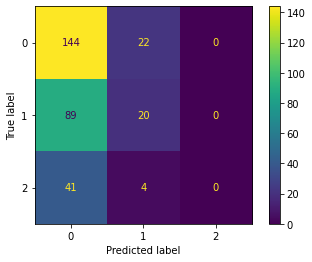

In [62]:
# con 1 palabra
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

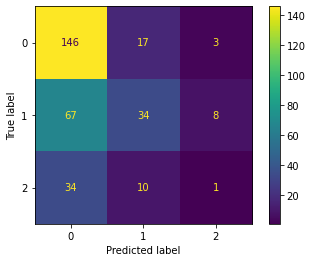

In [56]:
# con 10 palabras
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

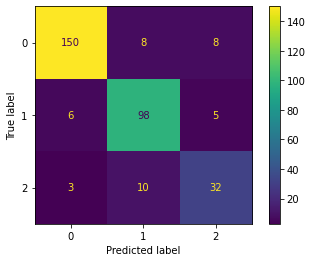

In [51]:
# con 10000 palabras
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

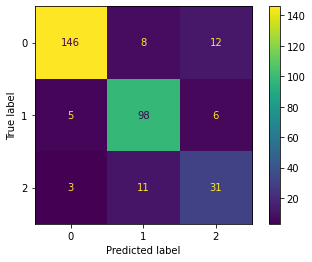

In [45]:
# con 1000 palabras
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

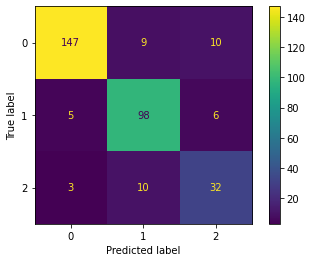

In [69]:
# con 1000 palabras máximo y minima frecuencia de 100
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

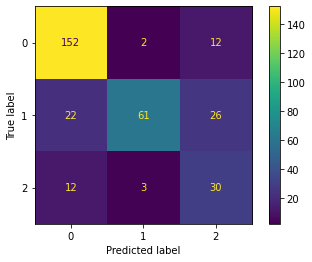

In [79]:
# con 1000 palabras máximo y minima frecuencia de 500
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

Vemos que a medida que reducimos el número de palabras, el modelo tiende a predecir a la clase más frecuente, en este caso la clase *mainstream*, acercándose al modelo trivial planteado para comparar. Sin embargo, con un número de palabras más elevado conseguimos una precisión muy superior.

Para medir la importancia de las stopwords, entrenamos un modelo habíendolas quitado

In [86]:
stopwords = nltk.corpus.stopwords.words('english')

In [90]:
X_train, y_train, X_test, y_test = get_and_bow_vectorize_data(max_tokens=1000, min_freq = 1, stop_words=stopwords)


100%|██████████| 320/320 [00:00<00:00, 951.22it/s]


In [91]:
logistic_classifier = tf.keras.Sequential()
logistic_classifier.add(tf.keras.layers.Dense(3, input_dim=np.shape(X_train)[1], activation="softmax"))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
logistic_classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=["accuracy"])
hist = logistic_classifier.fit(x=X_train, y=y_train, batch_size = len(y_train), epochs=10000,callbacks=[early_stop]);

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 10ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7502/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7503/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7504/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7505/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7506/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7507/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7508/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7509/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7510/10000
1/1 [=====================

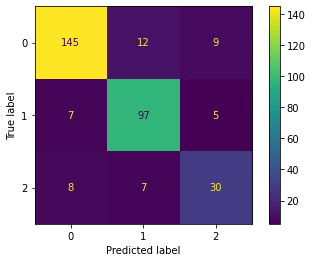

In [93]:
# con 100 palabras máximo, minima frecuencia de 100, sin stopwords
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

## Features selection

**Tarea 2: Implementar una vectorización por palabras claves. Es decir, definir un vocabulario inspeccionando las noticias de la base de datos y tratar de hipotetizar qué palabras pueden servir para discriminar entre noticias de izquierda, derecha y *mainstream*. Una  vez hecho esto, implementar nuevamente el clasificador anterior y utilizarlo para predecir en este nuevo escenario.**

Hint: para este análisis puede que sea necesario hacer una inspección de los datos y ver qué palabras aparecieron en cada categoría. En este punto, cualquier idea *out-of-the-box* también puede ser útil :)

In [100]:
df_left = train_split[train_split["orientation"] == "left"]
df_right = train_split[train_split["orientation"] == "right"]
df_mainstream = train_split[train_split["orientation"] == "mainstream"]

In [128]:
annoying_characters = [")", "(", ".", ",", "!", "?", "-", "_", "`"]
contains_annoying_char = lambda token: any([character in token for character in annoying_characters])
low_case_tokenize = lambda text: [token.lower() for token in word_tokenize(text)]
tokenize_removing_stopwords = lambda text: [token for token in low_case_tokenize(text) if token not in stopwords]
tokenize_removing_bad_tokens = lambda text: [token for token in tokenize_removing_stopwords(text)\
                                             if not contains_annoying_char(token) and len(token) > 1]

In [149]:
def most_popular_words(df:pd.DataFrame, numberOfWords = 10) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["tokens"] = df_copy["mainText"].map(tokenize_removing_bad_tokens)
    df_copy_tokens = df_copy[["tokens"]]
    df_copy_tokens_exploded = df_copy_tokens.explode("tokens")
    df_copy_count_by_word = df_copy_tokens_exploded.groupby("tokens").agg(appearances = ("tokens","count")) 
    df_copy_count_top = df_copy_count_by_word.sort_values("appearances", ascending = False).head(numberOfWords).reset_index()
    return df_copy_count_top

In [214]:
most_popular_words_left = most_popular_words(df_left, 20)
most_popular_words_right = most_popular_words(df_right, 20)
most_popular_words_mainstream = most_popular_words(df_mainstream, 20)

In [216]:
words_left = set(most_popular_words_left.tokens)
words_right = set(most_popular_words_right.tokens)
words_mainstream = set(most_popular_words_mainstream.tokens)

In [217]:
special_words = words_left.union(words_right.union(words_mainstream))
vocabulary = pd.Series(list(special_words)).to_frame()
vocabulary["1"] = 1
vocabulary

,0,1
0,hillary,1
1,police,1
2,campaign,1
3,trump,1
4,september,1
5,like,1
6,man,1
7,know,1
8,obama,1
9,would,1


In [218]:
def get_data_and_select_keywords(stop_words=None, vocab = []):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)
  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_data_and_select_keywords(None, vocabulary)


100%|██████████| 320/320 [00:01<00:00, 318.19it/s]


In [219]:
logistic_classifier = tf.keras.Sequential()
logistic_classifier.add(tf.keras.layers.Dense(3, input_dim=np.shape(X_train)[1], activation="softmax"))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
logistic_classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=["accuracy"])
hist = logistic_classifier.fit(x=X_train, y=y_train, batch_size = len(y_train), epochs=10000,callbacks=[early_stop]);

Epoch 1/10000
1/1 [==============================] - 0s 175ms/step - loss: 1.0986 - accuracy: 0.5109
Epoch 2/10000
1/1 [==============================] - 0s 6ms/step - loss: 1.0926 - accuracy: 0.5109
Epoch 3/10000
1/1 [==============================] - 0s 13ms/step - loss: 1.0870 - accuracy: 0.5109
Epoch 4/10000
1/1 [==============================] - 0s 6ms/step - loss: 1.0817 - accuracy: 0.5109
Epoch 5/10000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 0s 9ms/step - loss: 1.0768 - accuracy: 0.5109
Epoch 6/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0722 - accuracy: 0.5109
Epoch 7/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0679 - accuracy: 0.5109
Epoch 8/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.0639 - accuracy: 0.5109
Epoch 9/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.0602 - accuracy: 0.5109
Epoch 10/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0567 - accuracy: 0.5109
Epoch 11/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.0534 - accuracy: 0.5109
Epoch 12/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.0504 - accuracy: 0.5109
Epoch 13/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0475 - accuracy: 0.5109
Epoch 14/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0448 - accuracy: 0.5109
Epoch 15/10000
1/1 

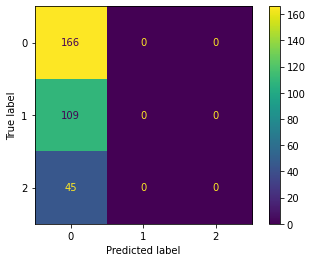

In [220]:
y_predicted = [int(np.where(output == np.max(output))[0]) for output in logistic_classifier.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()